In [1]:
from satisfying_sims.core import (
    SimConfig,
    make_world,
    World,
    BoxBoundary,
    step_physics,
    SpawnRandomShapes,
    LifetimeDecay,
)

/var/folders/qc/qhpnmhd50xx6mpxpb99h7pw00000gn/T/ipykernel_68292/4024234187.py:6: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


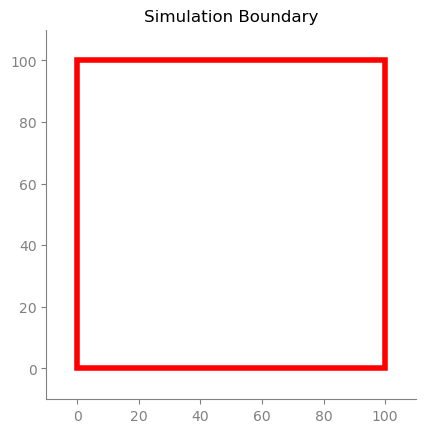

In [2]:
boundary = BoxBoundary(width=100.0, height=100.0)

fig, ax = boundary.plot(delta=10, edgecolor="red", linewidth=4)

ax.set_title("Simulation Boundary")
fig.show()

In [ ]:

sim_config = SimConfig(